In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/indian-bovine-breeds/bovine_breeds_metadata.csv
/kaggle/input/indian-bovine-breeds/Indian_bovine_breeds/Indian_bovine_breeds/Alambadi/Alambadi_49.jpg
/kaggle/input/indian-bovine-breeds/Indian_bovine_breeds/Indian_bovine_breeds/Alambadi/Alambadi_80.png
/kaggle/input/indian-bovine-breeds/Indian_bovine_breeds/Indian_bovine_breeds/Alambadi/Alambadi_67.jpg
/kaggle/input/indian-bovine-breeds/Indian_bovine_breeds/Indian_bovine_breeds/Alambadi/Alambadi_73.jpg
/kaggle/input/indian-bovine-breeds/Indian_bovine_breeds/Indian_bovine_breeds/Alambadi/Alambadi_59.png
/kaggle/input/indian-bovine-breeds/Indian_bovine_breeds/Indian_bovine_breeds/Alambadi/Alambadi_35.jpg
/kaggle/input/indian-bovine-breeds/Indian_bovine_breeds/Indian_bovine_breeds/Alambadi/Alambadi_96.jpg
/kaggle/input/indian-bovine-breeds/Indian_bovine_breeds/Indian_bovine_breeds/Alambadi/Alambadi_41.png
/kaggle/input/indian-bovine-breeds/Indian_bovine_breeds/Indian_bovine_breeds/Alambadi/Alambadi_78.png
/kaggle/input/indian

# Environment setup and Library Import

In [30]:
# === System & Utilities ===
import os
import sys
import warnings
from io import BytesIO

# === Data Handling ===
import numpy as np
import pandas as pd

# === Progress Visualization ===
from tqdm import tqdm
from tqdm.keras import TqdmCallback

# === Plotting & Visualization ===
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import seaborn as sns

# === Image Handling ===
import cv2
from PIL import Image
import requests

# === Machine Learning (Scikit-learn) ===
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    auc
)

# === TensorFlow & Keras ===
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress TF logs
stderr = sys.stderr
sys.stderr = open(os.devnull, 'w')       # Temporarily suppress stderr

# import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import AUC
from keras.utils import to_categorical

# sys.stderr = stderr  # Restore stderr

# === Other ===
import random

# === Warnings ===
warnings.filterwarnings('ignore')

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


# Dataset Directory setup and class Discovery

In [32]:
dataset_root = '/kaggle/input/indian-bovine-breeds/Indian_bovine_breeds'
train_dir = os.path.join(dataset_root, 'Indian_bovine_breeds')
test_dir = os.path.join(dataset_root, 'Indian_bovine_breeds')

# Automatically discover the class names (breed names)
labels = sorted([name for name in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, name))])
num_classes = len(labels)

print(f"\nFound {num_classes} classes (breeds).")
print("First 5 class names:", labels[:5])


Found 41 classes (breeds).
First 5 class names: ['Alambadi', 'Amritmahal', 'Ayrshire', 'Banni', 'Bargur']


# Image loading and preprocessing

In [33]:
image_data, label_data = [], []
image_size = 150  # VGG16 works well with this size

label_map = {label: i for i, label in enumerate(labels)}

for data_dir_name in ["Indian_bovine_breeds", "Indian_bovine_breeds"]:
    data_path = os.path.join(dataset_root, data_dir_name)
    print(f"\n📂 Processing '{data_dir_name}' directory...")
    
    for label in tqdm(labels, desc=f'Loading {data_dir_name} images'):
        breed_dir = os.path.join(data_path, label)
        if not os.path.exists(breed_dir):
            continue
            
        for img_file in os.listdir(breed_dir):
            img_path = os.path.join(breed_dir, img_file)
            try:
                image_cv = cv2.imread(img_path)
                if image_cv is None: continue
                
                image_cv = cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB)
                image_cv = cv2.resize(image_cv, (image_size, image_size))
                
                image_data.append(image_cv)
                label_data.append(label_map[label])
            except Exception as e:
                print(f"❌ Error processing file {img_path}: {e}")

print(f"\n✅ Data processing complete! Loaded {len(image_data)} images.")


📂 Processing 'Indian_bovine_breeds' directory...

📂 Processing 'Indian_bovine_breeds' directory...

✅ Data processing complete! Loaded 11898 images.


# Data Shuffing , Normalization & Splitting

In [34]:
image_data, label_data = shuffle(image_data, label_data, random_state=42)
image_data = np.array(image_data, dtype=np.float32) / 255.0
label_data = np.array(label_data, dtype=np.int32)

X_train, X_test, Y_train_raw, Y_test_raw = train_test_split(
    image_data, label_data, test_size=0.2, random_state=42, stratify=label_data
)

Y_train = to_categorical(Y_train_raw, num_classes=num_classes)
Y_test = to_categorical(Y_test_raw, num_classes=num_classes)

print(f"\n✅ Data ready for training!")
print(f"   Training samples: {len(X_train)}")
print(f"   Test samples: {len(X_test)}")


✅ Data ready for training!
   Training samples: 9518
   Test samples: 2380


Total images are 5949


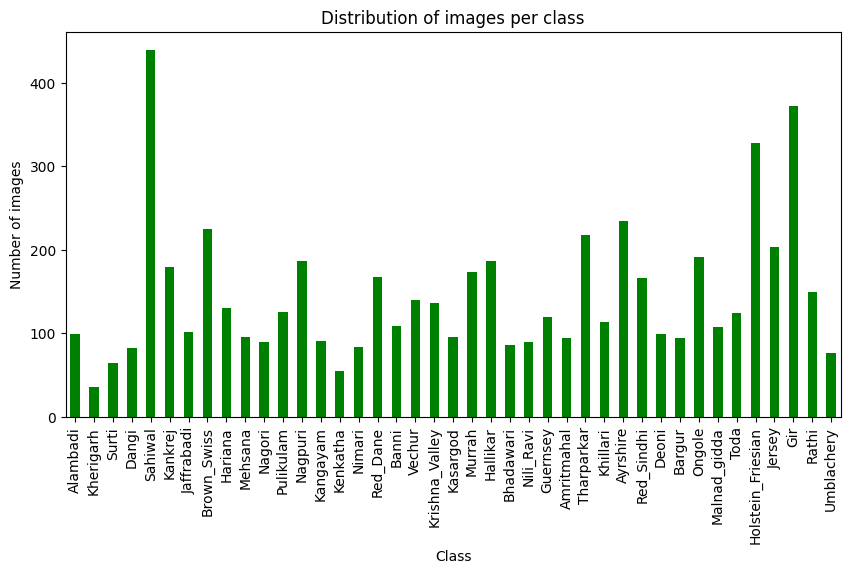

In [18]:
# Get the list of class labels from the training directory
classes = os.listdir(train_dir)

# Count the number of images in each class folder
image_counts = {cls: len(os.listdir(os.path.join(train_dir, cls))) for cls in classes}

# Calculate and print the total number of images across all classes
total = sum(image_counts.values())
print(f"Total images are {total}")

# Plot a bar chart showing the number of images per class
plt.figure(figsize=(10, 5))
pd.Series(image_counts).plot(kind='bar', color='g')
plt.title('Distribution of images per class')
plt.xlabel('Class')
plt.ylabel('Number of images')
plt.show()

# VGG16 model 

In [35]:
vgg = VGG16(input_shape=(image_size, image_size, 3), weights='imagenet', include_top=False)

for layer in vgg.layers:
    layer.trainable = False

x = Flatten()(vgg.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
prediction = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=vgg.input, outputs=prediction)
print("\n✅ VGG16-based model constructed.")
model.summary()


✅ VGG16-based model constructed.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 41)             │        10,53

 Total params: 19,051,369 (72.68 MB)

 Trainable params: 4,336,681 (16.54 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

# Model compilation and Claabacks confugration

In [36]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss=CategoricalCrossentropy(),
    metrics=['accuracy', AUC(name='auc')]
)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1)

print("\n✅ Model compiled successfully!")


✅ Model compiled successfully!


# Model training

In [37]:
print("\n🚀 Starting model training...")
history = model.fit(
    X_train, Y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, Y_test),
    callbacks=[early_stopping, reduce_lr, TqdmCallback(verbose=1)],
    verbose=0
)
print("\n✅ Model training finished!")


🚀 Starting model training...


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]


Epoch 45: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
Restoring model weights from the end of the best epoch: 49.

✅ Model training finished!


In [38]:
model.save("breeds_classification.h5")

# TRAINING METRICS VISUALIZATION

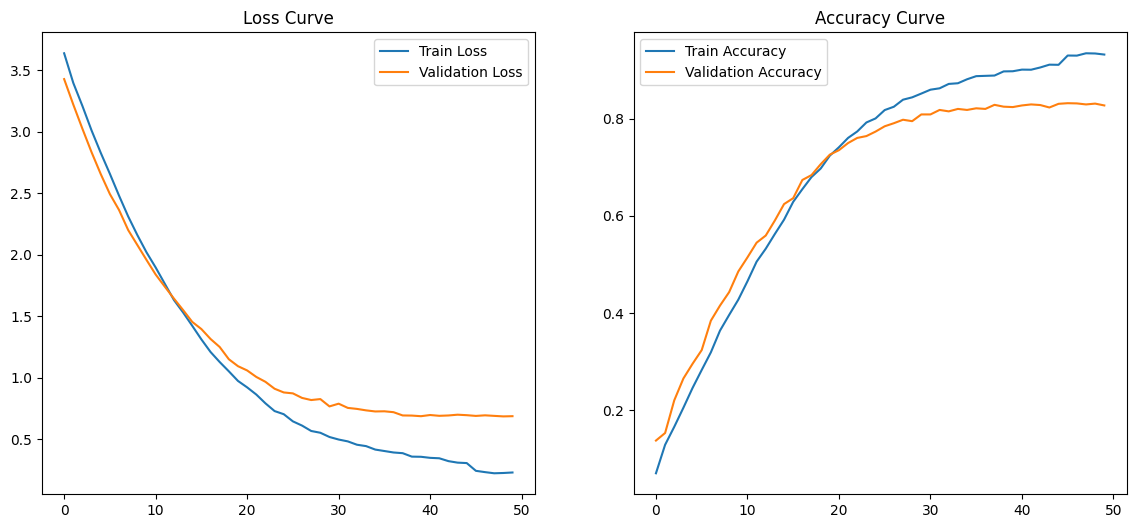

In [40]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.legend()
plt.show()

# CLASSIFICATION REPORT

In [41]:
predictions = model.predict(X_test)
y_pred_indices = np.argmax(predictions, axis=1)
print("\nClassification Report:\n")
print(classification_report(Y_test_raw, y_pred_indices, target_names=labels))


75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step

Classification Report:

                   precision    recall  f1-score   support

         Alambadi       0.97      0.95      0.96        40
       Amritmahal       0.93      0.74      0.82        38
         Ayrshire       0.90      0.83      0.86        94
            Banni       0.94      0.75      0.84        44
           Bargur       1.00      0.92      0.96        38
        Bhadawari       0.63      0.56      0.59        34
      Brown_Swiss       0.90      0.89      0.89        90
            Dangi       0.94      0.88      0.91        33
            Deoni       0.97      0.82      0.89        40
              Gir       0.88      0.90      0.89       149
         Guernsey       0.80      0.85      0.83        48
         Hallikar       0.81      0.84      0.82        74
          Hariana       0.81      0.88      0.84        52
Holstein_Friesian       0.86      0.92      0.89       131
       Jaffrabadi       0.89      0.95      0.92 

# SAVING THE TRAINED MODEL

In [42]:
model.save("bovine_breed_classifier_vgg16.h5")
print("\n✅ Model saved as 'bovine_breed_classifier_vgg16.h5'")


✅ Model saved as 'bovine_breed_classifier_vgg16.h5'
